### Using a pretrained model and dataset from huggingface

I aimed to use a text classification dataset.  Searching for a small sized one I selected the `jailbreak` dataset which is a binary classification task to predict whether a prompt is a jailbreak attempt or benign.

### Loading as a dataset

In [ ]:
from datasets import load_dataset
#loading directly -- from docs
ds = load_dataset("jackhhao/jailbreak-classification")

The dataset is essentially a dictionary with a train and test dataset.  It contains two columns, the text of the prompt and a type -- benign or jailbreak.

In [ ]:
ds

In [ ]:
ds['train'][0]

In [ ]:
ds['train'][1]

### Loading the Model and Tokenizer

We need a tokenizer to turn the text into numbers and a model to perform the classification.  Below, we load in the Bert tokenizer and Bert model for sequence classification.  The `tokenizer` will be applied to the dataset and then passed to the model for training.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

In [ ]:
#example of tokenizer
tokenizer(ds['train'][0]['prompt'])

In [ ]:
#function to apply tokenizer to all input strings
#note that this is the text in the "prompt" column
def encode(examples):
    return tokenizer(examples['prompt'], truncation=True, padding="max_length")

In [ ]:
#mapping tokenizer to dataset
data = ds.map(encode)

In [ ]:
#function to make target numeric
#note these are the 'type' column and model expects 'labels'
def targeter(examples):
  return {'labels': 1 if examples['type'] == 'jailbreak' else 0}

In [ ]:
#map target function to data
data = data.map(targeter)

In [ ]:
#note the changed data
data['train'][0]

In [ ]:
#no longer need original columns in data
d = data.remove_columns(['prompt', 'type'])

### Using the `Trainer` api

To train the model to predict jailbreak or not we use the `Trainer` and `TrainingArguments` objects from huggingface.

The `Trainer` requires a model, dataset specification, and tokenizer.  We use our dataset and the appropriate keys and create a `TrainingArguments` object to define where to store the model.  Once instantiated, the `.train` method begins the model training.

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
ta = TrainingArguments('testing-jailbreak',remove_unused_columns=False)

In [ ]:
trainer = Trainer(model = model,
                  args = ta,
                  train_dataset = d['train'],
                  eval_dataset = d['test'],
                  processing_class = tokenizer, )

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:


KeyboardInterrupt: 

### Evaluating the Model

After training, we using the model to predict on the test (evaluation) dataset.  The predictions are logits and we interpret them like probabilities.  Whatever the larger value, we predict based on the column index -- 0 or 1.  To do this, we use the `np.argmax` function.

Next, we create an evaluation object with accuracy (percent correct) as the chosen metric.  The `.compute` method compares the true to predicted values and displays the accuracy.

In [ ]:
#make predictions
preds = trainer.predict(d['test'])

In [ ]:
#first few rows of predictions
preds.predictions[:5]

In [ ]:
import numpy as np

In [ ]:
#turning predictions into 0 and 1
yhat = np.argmax(preds.predictions, axis = 1)

In [ ]:
# !pip install evaluate

In [ ]:
import evaluate

In [ ]:
#create accuracy evaluater
acc = evaluate.load("accuracy")

In [ ]:
#accuracy on test data
acc.compute(predictions = yhat,
            references=preds.label_ids)

In [ ]:
#baseline accuracy
preds.label_ids.sum()/len(preds.label_ids)

### Task: Fine Tuning a Time Series Model

The `Trainer` api essentially exposes all huggingface models and the ability to fine tune them readily.  Your goal for this assignment is to find a time series dataset (large in that it has more than 500K rows) and fine tune a forecasting model on this data.  [Huggingface time series models](https://huggingface.co/models?pipeline_tag=time-series-forecasting&sort=trending). Read through the article "A comprehensive survey of deep learning for time series forecasting: architectural diversity and open challenges" [here](https://link.springer.com/article/10.1007/s10462-025-11223-9) and discuss the summary of your models architecture and design as relate to the author's comments.  (i.e. is it a transformer, a cnn, lstm, etc.)

One option is the `sktime.datasets.ForecastingData.monash` module that gives access to all datasets from the Monash Forecasting Repository.  These are shown below.  

The result of your work should be a notebook with the training of the model and a brief writeup of the models performance and forecasting task.  Create a github repository with this work and share the url.

In [1]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 7.8 MB/s eta 0:00:00


In [2]:
from sktime.datasets import ForecastingData

In [3]:
ForecastingData.all_datasets()

['m1_yearly_dataset',
 'm1_quarterly_dataset',
 'm1_monthly_dataset',
 'm3_yearly_dataset',
 'm3_quarterly_dataset',
 'm3_monthly_dataset',
 'm3_other_dataset',
 'm4_yearly_dataset',
 'm4_quarterly_dataset',
 'm4_monthly_dataset',
 'm4_weekly_dataset',
 'm4_daily_dataset',
 'm4_hourly_dataset',
 'tourism_yearly_dataset',
 'tourism_quarterly_dataset',
 'tourism_monthly_dataset',
 'cif_2016_dataset',
 'london_smart_meters_dataset_with_missing_values',
 'london_smart_meters_dataset_without_missing_values',
 'australian_electricity_demand_dataset',
 'wind_farms_minutely_dataset_with_missing_values',
 'wind_farms_minutely_dataset_without_missing_values',
 'dominick_dataset',
 'bitcoin_dataset_with_missing_values',
 'bitcoin_dataset_without_missing_values',
 'pedestrian_counts_dataset',
 'vehicle_trips_dataset_with_missing_values',
 'vehicle_trips_dataset_without_missing_values',
 'kdd_cup_2018_dataset_with_missing_values',
 'kdd_cup_2018_dataset_without_missing_values',
 'weather_dataset',


In [4]:
# Install necessary libraries for time series forecasting
!pip install sktime torch matplotlib numpy pandas


In [5]:
# Basic scientific computing and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch


In [6]:
# Import ForecastingData interface from sktime
# This provides access to the Monash Forecasting Repository
from sktime.datasets import ForecastingData

# List all available forecasting datasets
ForecastingData.all_datasets()


['m1_yearly_dataset',
 'm1_quarterly_dataset',
 'm1_monthly_dataset',
 'm3_yearly_dataset',
 'm3_quarterly_dataset',
 'm3_monthly_dataset',
 'm3_other_dataset',
 'm4_yearly_dataset',
 'm4_quarterly_dataset',
 'm4_monthly_dataset',
 'm4_weekly_dataset',
 'm4_daily_dataset',
 'm4_hourly_dataset',
 'tourism_yearly_dataset',
 'tourism_quarterly_dataset',
 'tourism_monthly_dataset',
 'cif_2016_dataset',
 'london_smart_meters_dataset_with_missing_values',
 'london_smart_meters_dataset_without_missing_values',
 'australian_electricity_demand_dataset',
 'wind_farms_minutely_dataset_with_missing_values',
 'wind_farms_minutely_dataset_without_missing_values',
 'dominick_dataset',
 'bitcoin_dataset_with_missing_values',
 'bitcoin_dataset_without_missing_values',
 'pedestrian_counts_dataset',
 'vehicle_trips_dataset_with_missing_values',
 'vehicle_trips_dataset_without_missing_values',
 'kdd_cup_2018_dataset_with_missing_values',
 'kdd_cup_2018_dataset_without_missing_values',
 'weather_dataset',


In [19]:
# Load the M4 daily dataset
# This dataset contains more than 500,000 time series observations
# Install compatible versions (safe in Colab)
!pip install -U sktime pandas numpy

# Import the correct loader for M4
from sktime.datasets import load_forecastingdata

# Load the M4 Daily dataset
y_data, y_metadata = load_forecastingdata("m4_daily_dataset")

# Print dataset size information (used as evidence for bonus requirement)
num_series = y_data.index.get_level_values(0).nunique()

# Calculate total number of individual observations
total_individual_observations = y_data['series_value'].apply(len).sum()

print("Total number of time series:", num_series)
print("Total number of individual observations across all series:", total_individual_observations)

Total number of time series: 4227
Total number of individual observations across all series: 10023836


In [10]:
# Select a small subset of series for modeling (for speed)
series_ids = y_data.index.get_level_values(0).unique()[:10]
y_small = y_data.loc[series_ids]

print("Using number of time series:", len(series_ids))
print("Using number of observations:", len(y_small))


Using number of time series: 10
Using number of observations: 10


In [22]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
import pandas as pd # Import pandas for Series conversion

# Split each time series into train and test
y_train, y_test = temporal_train_test_split(
    y_small,
    test_size=1  # keep last 1 observation per series
)

# Define a naive forecasting model
forecaster = NaiveForecaster(strategy="last")

# Fit the model, converting the lists in 'series_value' to pd.Series objects
forecaster.fit(y_train['series_value'].apply(pd.Series))

# Define forecast horizon: forecast the next 10 steps
fh = list(range(1, 11))

# Generate forecasts
y_pred = forecaster.predict(fh=fh)

# Print result summary
print("Forecast generated successfully")
print(y_pred.head())

Forecast generated successfully
       0       1        2        3        4        5        6        7     \
9   1006.71  1002.4  1009.45  1006.56  1016.87  1017.25  1024.52  1021.84   
10  1006.71  1002.4  1009.45  1006.56  1016.87  1017.25  1024.52  1021.84   
11  1006.71  1002.4  1009.45  1006.56  1016.87  1017.25  1024.52  1021.84   
12  1006.71  1002.4  1009.45  1006.56  1016.87  1017.25  1024.52  1021.84   
13  1006.71  1002.4  1009.45  1006.56  1016.87  1017.25  1024.52  1021.84   

       8        9     ...     1010     1011     1012      1013      1014  \
9   1029.34  1020.61  ...  1585.83  1583.43  1581.94  7850.555  7280.313   
10  1029.34  1020.61  ...  1585.83  1583.43  1581.94  7850.555  7280.313   
11  1029.34  1020.61  ...  1585.83  1583.43  1581.94  7850.555  7280.313   
12  1029.34  1020.61  ...  1585.83  1583.43  1581.94  7850.555  7280.313   
13  1029.34  1020.61  ...  1585.83  1583.43  1581.94  7850.555  7280.313   

        1015      1016      1017      1018      

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the true last observed value for each series
y_true = y_test["series_value"].apply(lambda x: x[0]).values

# Extract the first-step forecast for each series, aligning with the series in y_test
y_hat = y_pred.loc[y_test.index, 0].values

# Compute MAE and RMSE
mae = mean_absolute_error(y_true, y_hat)
rmse = np.sqrt(mean_squared_error(y_true, y_hat))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1069.4899999999998
RMSE: 1069.4899999999998


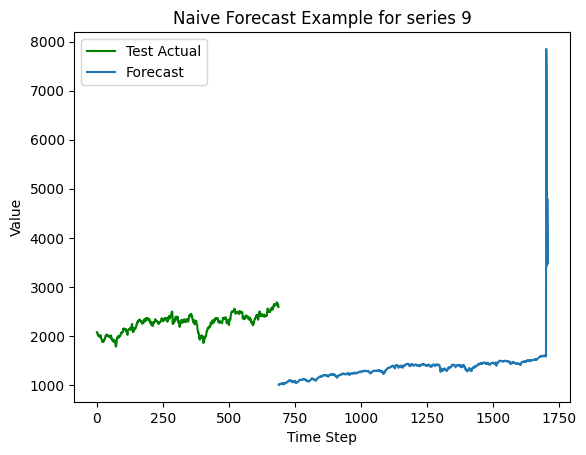

In [28]:
import matplotlib.pyplot as plt

# Get the series_id that is actually present in y_test
series_id_to_plot = y_test.index[0] # This will be 9 based on kernel state

# Plot the actual test data for the selected series
# We plot this with its default index starting from 0 for simplicity,
# as we are not plotting the train data for this specific series.
plt.plot(pd.Series(y_test.loc[series_id_to_plot, "series_value"]).reset_index(drop=True), label="Test Actual", color='green')

# Plot the forecast for the selected series
# The x-axis for the forecast should start immediately after the test actual data
# and have the same length as the forecast itself.
forecast_values = y_pred.loc[series_id_to_plot]
len_test_actual = len(y_test.loc[series_id_to_plot, "series_value"])
len_forecast = len(forecast_values)

plt.plot(
    range(len_test_actual, len_test_actual + len_forecast),
    forecast_values,
    label="Forecast"
)

plt.legend()
plt.title(f"Naive Forecast Example for series {series_id_to_plot}")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.show()